In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import sys

sys.path.append('..')

from algorithms.random_policy import RandomPolicy
from algorithms.sequence_models.decision_sequence_policy import DTPolicy
from algorithms.sequence_models.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.evaluate import evaluate_on_env
from data.door_key_dataset import DoorKeyDataset
from data.random_walk_dataset import RandomWalkDataset
from envs.door_key import DoorKeyEnv, DoorKeyEnvSmall
from data.trajectory import LimitedContextWrapper
from algorithms.sequence_models.config import TrainConfig
from algorithms.sequence_models.decision_transformer.trainer import TrainerDT
from envs.random_walk import RandomWalkEnv
from experiment import Experiment
import gymnasium as gym
from functools import partial

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is ", device)

/snap/pycharm-professional/387/plugins/python/helpers/pydev/pydevd_plugins/__init__.py:2: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydevd_plugins')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__('pkg_resources').declare_namespace(__name__)
/snap/pycharm-professional/387/plugins/python/helpers/pydev/pydevd_plugins/extensions/__init__.py:2: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydevd_plugins.extensions')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__('pkg_resources').declare_namespace(__name__)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device is  cuda


/snap/pycharm-professional/387/plugins/python/helpers/pydev/pydevd_plugins/extensions/types/__init__.py:2: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydevd_plugins.extensions.types')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__('pkg_resources').declare_namespace(__name__)


# Random Walk Env

# Door Key Env

In [22]:
from minigrid.wrappers import ImgObsWrapper

inner_env = gym.make('MiniGrid-DoorKey-5x5-v0')
inner_env_human = gym.make('MiniGrid-DoorKey-5x5-v0', render_mode='human')
env = ImgObsWrapper(inner_env)
env_human = ImgObsWrapper(inner_env_human)


config = TrainConfig(max_eval_ep_len=env.max_steps, context_len=32)

# todo save the dataset for the experiment
traj_dataset = DoorKeyDataset(env, n_trajectories=100, reward_scale=20)

model = DecisionTransformer(
    state_dim=traj_dataset.state_dim(),
    act_dim=traj_dataset.action_dim(),
    n_blocks=config.n_blocks,
    h_dim=config.embed_dim,
    context_len=config.context_len,
    n_heads=config.n_heads,
    drop_p=config.dropout_p,
).to(device)

DoorKeyDTPolicy = partial(DTPolicy, model=model, traj_dataset=traj_dataset, device=device, max_test_ep_len=config.max_eval_ep_len, context_length=config.context_len)

experiment = Experiment(
    model_name='dt',
    model=model,
    env_name='MiniGrid-DoorKey-5x5-v0',
    env=env,
    experiment_name='starter',
    traj_dataset=traj_dataset,
    dataset_name=f'size={len(traj_dataset)}',
    config=config,
    device=device,
    eval_policies_and_names=[
        (DoorKeyDTPolicy(rtg=rtg), f'dt,rtg={rtg}')
        for rtg in np.linspace(0, 1.5, 10)
    ]
)

/home/shayan/miniconda3/envs/rl-explore/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.max_steps to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.max_steps` for environment variables or `env.get_wrapper_attr('max_steps')` that will search the reminding wrappers.
  logger.warn(


collecting trajectories:   0%|          | 0/100 [00:00<?, ?it/s]

Dataset Info:
episode_max_length: 250
reward_scale: 20
return min=0.0, max=0.6796 mean=0.034496
gamma: 1
number of parameters 1159579


In [23]:
report = experiment.train_for(10)

training started


  0%|          | 0/10 [00:00<?, ?it/s]

time elapsed: 0:00:01
num of updates: 100
loss: 0.32795
lr 0.00001
grad_norm 0.18637
time elapsed: 0:00:02
num of updates: 200
loss: 0.24357
lr 0.00002
grad_norm 0.16325
time elapsed: 0:00:03
num of updates: 300
loss: 0.16940
lr 0.00003
grad_norm 0.09592
time elapsed: 0:00:04
num of updates: 400
loss: 0.13692
lr 0.00004
grad_norm 0.08461
time elapsed: 0:00:05
num of updates: 500
loss: 0.12936
lr 0.00005
grad_norm 0.08169
time elapsed: 0:00:06
num of updates: 600
loss: 0.12701
lr 0.00006
grad_norm 0.08252
time elapsed: 0:00:07
num of updates: 700
loss: 0.12549
lr 0.00007
grad_norm 0.07649
time elapsed: 0:00:07
num of updates: 800
loss: 0.12458
lr 0.00008
grad_norm 0.08585
time elapsed: 0:00:08
num of updates: 900
loss: 0.12376
lr 0.00009
grad_norm 0.16638
time elapsed: 0:00:09
num of updates: 1000
loss: 0.12326
lr 0.00010
grad_norm 0.13155
saving current model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/MiniGrid-DoorKey-5x5-v0/dt/starter/starter_size=100_model_model_2

<Axes: >

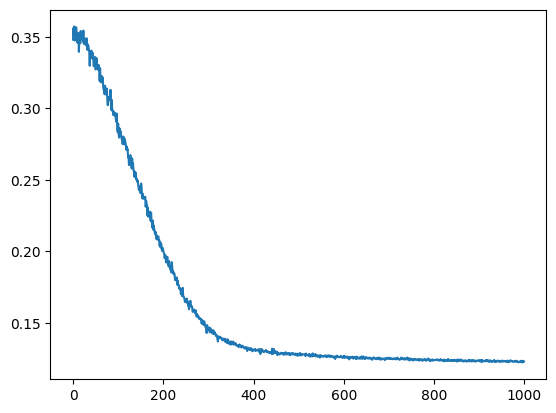

In [24]:
experiment.plot_loss(report)

training started


  0%|          | 0/100 [00:00<?, ?it/s]

time elapsed: 0:00:01
num of updates: 1100
loss: 0.12349
lr 0.00011
grad_norm 0.09986
saving current model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/MiniGrid-DoorKey-5x5-v0/dt/starter/starter_size=500_model_model_24-05-11-22-11-08.pt
saving best model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/MiniGrid-DoorKey-5x5-v0/dt/starter/starter_size=500_model_model_24-05-11-22-11-08_best.pt
time elapsed: 0:00:05
num of updates: 1200
loss: 0.12335
lr 0.00012
grad_norm 0.16646
saving current model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/MiniGrid-DoorKey-5x5-v0/dt/starter/starter_size=500_model_model_24-05-11-22-11-08.pt
saving best model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/MiniGrid-DoorKey-5x5-v0/dt/starter/starter_size=500_model_model_24-05-11-22-11-08_best.pt
time elapsed: 0:00:08
num of updates: 1300
loss: 0.12317
lr 0.00013
grad_norm 0.15133
saving current model at: /home/shayan/projects/RL-credit-assig

,train/loss,train/update_idx,train/iteration
0,0.123599,0,0
1,0.124067,1,0
2,0.123471,2,0
3,0.123764,3,0
4,0.124046,4,0
...,...,...,...
95,0.093862,95,99
96,0.099420,96,99
97,0.099149,97,99
98,0.103188,98,99


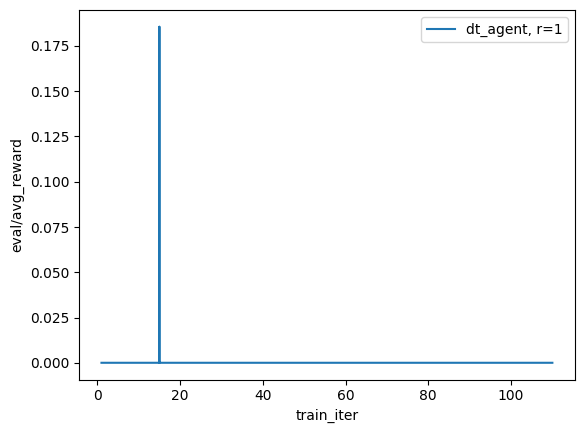

In [11]:
experiment.train_for(100)

### how to evaluate policy?

In [25]:
from algorithms.evaluate_policy import evaluate_policy

DoorKeyDTPolicy = partial(DTPolicy, model=model, traj_dataset=traj_dataset, device=device, max_test_ep_len=config.max_eval_ep_len, context_length=config.context_len)

# one way: use DTPolicy and evaluate_policy
policy = DoorKeyDTPolicy(rtg=1)
evaluate_policy(policy, env, num_eval_ep=config.num_eval_ep, max_test_ep_len=config.max_eval_ep_len)


{'eval/avg_reward': 0.0, 'eval/avg_ep_len': 250.0}

In [26]:
# or manually evaluate!

obs, _ = env.reset()
policy.reset()  # important
done = False

while not done:
    action = policy.predict(obs)
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    policy.add_to_history(obs, action, reward, done) # important
    print(obs, reward, action)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [2 5 0]
  [2 5 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [2 5 0]
  [5 4 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [2 5 0]
  [1 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [2 5 0]
  [1 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [2 5 0]
  [2 5 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]] 0 1
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [2 5 0]
  [2 5 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [2 5 0]
  [5 4 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [2 5 0]
  [1 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [2 5 0]
  [1 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [2 5 0]
  [2 5 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]
